# Data Reading

The goal is to convert this into a separate data-reading module with functions stored in an external .py file. Started 2 August 2019.

### Reading in high-resolution optical FITS files of Gaia 17bpi

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [4]:
testobject = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Data/Gaia 17bpi/gaia17bpi.20181103'
rvobject = +4.5



image, header = fits.getdata(testobject+'_1.fits',header=True)
ccdMax1 = np.shape(image)[0]
image, header = fits.getdata(testobject+'_2.fits',header=True)
ccdMax2 = np.shape(image)[0]
image, header = fits.getdata(testobject+'_3.fits',header=True)
ccdMax3 = np.shape(image)[0]

# with the routine read_spectrum looking like this:

def read_spectrum(star_name, ccd_num, n, wRange=[], section=False, entire=False, plot=False): 
    
    # add wavelength range parameter  <--- is this not wRange?
    # add glob to plot all three ccds at once
    
    '''Read one file and plot spectrum. Order number n must be ≥ 1 and can plot either one 
    order or entire spectrum.

    Ex: read_spectrum('ptf10qpf_20160520', 1, 4, section=False, entire=True) plots all orders
    '''
    if (wRange == [] or wRange == [-1, -1]) and entire == False:
        section = True
    filename = '{0}_{1}.fits'.format(star_name, ccd_num)
    image,header = fits.getdata(filename,header=True) #extracts image values and header
    number = n-1 #to account for python counting system
    if section or (wRange != [] and wRange != [-1,-1]): #plots one order for one file
        if n<=9:
            start_wav = header['CRVL1_0{0:}'.format(n)]  #extracts starting wavelength value for one order
            step = header['CDLT1_0{0:}'.format(n)] #extracts step value for one order
        if n>9: #this deals with the CR..._0n vs CR..._10 one digit/two digit issue
            start_wav = header['CRVL1_{0:}'.format(n)]
            step = header['CDLT1_{0:}'.format(n)]
        wave = np.arange(len(image[number]))*step+start_wav # combines evenly spaced values in length of the image 
        # in that order, then multiplies by step and adds start wavelength to create a set of reasonable wavelengths
        waveSection = np.copy(wave)
        if wRange != [] and wRange != [-1,-1]:
            minWavelength = min(wRange)
            maxWavelength = max(wRange)
            if minWavelength < min(wave) or minWavelength > max(wave):
                raise ValueError('Minimum wavelength out of bounds,\n'
                                 + 'wavelength range: {0}, order range: {1}'.format(wRange,[min(wave),max(wave)]))
            elif maxWavelength < min(wave) or maxWavelength > max(wave):
                raise ValueError('Maximum wavelength out of bounds,\n'
                                 + 'wavelength range: {0}, order range: {1}'.format(wRange,[min(wave),max(wave)]))
            newWaveRange = np.where(np.logical_and(wave >= minWavelength, wave <= maxWavelength))[0]
            wave = wave[newWaveRange]
            minIndex = int((minWavelength - start_wav) / step)
            maxIndex = int((maxWavelength - start_wav) / step)
            if plot:
              # print('minIndex = {0}, maxIndex = {1}, length = {2}'.format(minIndex, maxIndex, len(image[number])))
                plt.ion()
                plt.figure(figsize=(8,6))
                plt.clf()
              # print(wave)
              # print(image[number][minIndex:maxIndex])
              # print('length of wave: {0}, length of image[number]: {1}'.format(len(wave), len(image[number][minIndex:maxIndex+1])))
                plt.plot(wave,image[number][minIndex:maxIndex])
                plt.xlabel('Wavelength (A)')
                plt.title('Section from file '+str(filename)+' from order '+str(n))
        if plot and section:
            plt.ion()
            #plt.figure(3)
            plt.figure(figsize=(8,6))
            plt.clf()
            plt.plot(waveSection,image[number])
            plt.xlabel('Wavelength (A)')
            plt.title('Section from file'+str(filename)+' from order '+str(n))
        
    if entire: # plots all orders for one file
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.ion()
        waveCurrent = -1
        waveEntire = np.array([-1.0])
        fluxEntire = np.array([-1.0])
        for x in range(1,22): 
            try:
                if x<=9:
                    start_wav = header['CRVL1_0{0:}'.format(x)]
                    step = header['CDLT1_0{0:}'.format(x)]
                if x>9:
                    start_wav = header['CRVL1_{0:}'.format(x)]
                    step = header['CDLT1_{0:}'.format(x)]   
                waveCurrent = np.arange(len(image[x-1]))*step+start_wav
                np.append(waveEntire, waveCurrent)
                np.append(fluxEntire, image[x-1])
                if plot:
                    plt.plot(waveCurrent,image[x-1])
                    plt.title('Spectrum from all orders in file '+filename)
                    plt.xlabel('Wavelength (A)')
            except:
              # print 'error: order '+str(x)+' missing keyword {0:}'.format(x)  <--- why is this here?
                pass
        np.delete(waveEntire, 0)
        np.delete(fluxEntire, 0)
    if wRange != [] and wRange != [-1,-1]:
        return np.copy(wave), np.copy(image[number][minIndex:maxIndex])
    elif section:
        return np.copy(waveSection), np.copy(image[number])
    elif entire:
        return np.copy(waveEntire), np.copy(fluxEntire)
    else:
        return 'null', 'null'

Play with this by changing ccd and order!

In [40]:
star_name = testobject
ccd = 1
order = 3
# st_dev = 0.1
wave, flux = read_spectrum(star_name, ccd, order)

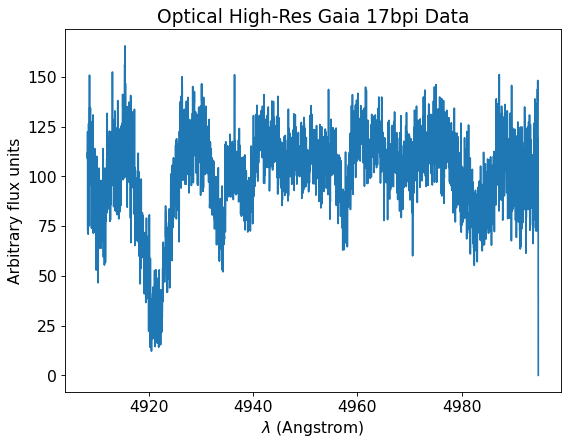

In [41]:
fig=plt.figure(figsize=(8, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(wave, flux)
plt.title('Optical High-Res Gaia 17bpi Data')
plt.xlabel(r'$\lambda$ (Angstrom)')
plt.ylabel('Arbitrary flux units')
plt.show()

### Reading in and cleaning moderate-resolution infrared spectra of Gaia 17bpi

In [4]:
def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [5]:
def cleanPoints(waves, lums, regions):
    waves_final, lums_final = [], []
    exclude = []
    for i in range(len(regions)):
        start, end = regions[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        bad_points = np.arange(ind_lower, ind_upper+1, 1)
        for i in range(len(bad_points)):
            exclude.append(bad_points[i])

    waves_final = np.delete(waves, exclude)
    lums_final = np.delete(lums, exclude)
    return waves_final, lums_final

In [6]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/Gaia 17bpi/'
REGIONS = np.array([(1e3, 8.5e3), (13e3, 15e3), (17.5e3, 19.8e3), (24.2e3, 26.5e3)])
DIST = 1.27e3*3.08567758128e18

In [7]:
newtxt = getDataArray(PATH + 'infrared_med.txt')

wavesDATA_INF = newtxt[:,0] 
fluxesDATA_INF = newtxt[:,1]

In [8]:
waves_DAT, fluxes_DAT = cleanPoints(wavesDATA_INF, fluxesDATA_INF, REGIONS)

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


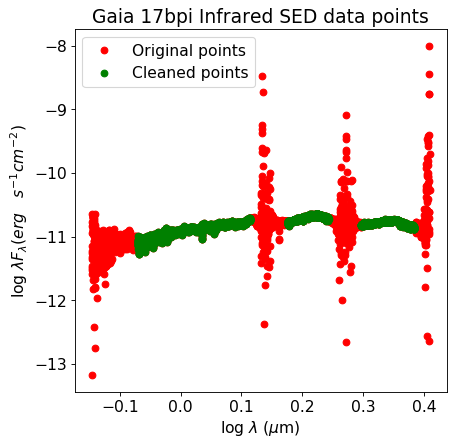

In [9]:
fig=plt.figure(figsize=(6, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')

plt.title('Gaia 17bpi Infrared SED data points')

plt.plot(np.log10(wavesDATA_INF*1e-4), np.log10(fluxesDATA_INF * wavesDATA_INF), 'ro', label='Original points')
plt.plot(np.log10(waves_DAT*1e-4), np.log10(fluxes_DAT * waves_DAT), 'go', label='Cleaned points')
plt.legend()
plt.show()

## Reading in Palomar Data

In [10]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/HBC 722/'

def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

def getDataValues(data_file):
    wav = getDataArray(data_file)[:,0]
    flux = getDataArray(data_file)[:,1]
    return wav, flux

In [11]:
REG_HBC =  np.array([(1e3, 7.7e3), (8.1e3, 8.35e3), (8.9e3, 10e3)])

In [22]:
wavesDATA_INF[6500] - wavesDATA_INF[6499]

3.5790000000015425

In [12]:
wav_blue, flux_blue = getDataValues(PATH + 'blue0109_flux.spec.txt')

wav_red, flux_red = getDataValues(PATH + 'red0109_flux.spec.txt')
wav_red, flux_red = cleanPoints(wav_red, flux_red, REG_HBC)

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


Blowing up the error bars by 10 for visual effect.

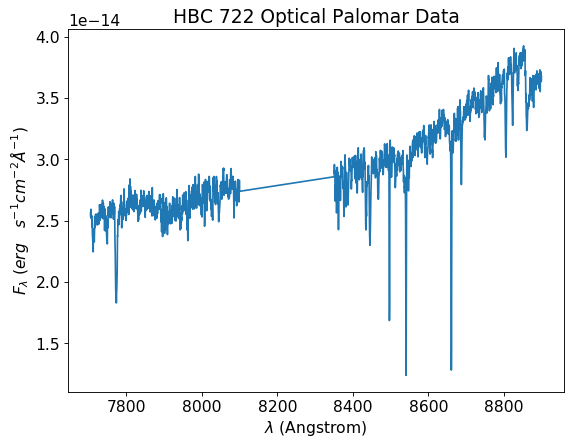

In [13]:
fig=plt.figure(figsize=(8, 6), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.plot(wav_red[10:], flux_red[10:])
# plt.xlim(4500, 5000)
plt.xlabel(r'$\lambda$ (Angstrom)')
plt.ylabel(r'$ F_\lambda\; (erg\quad s^{-1} cm^{-2} \AA^{-1})$')

plt.title('HBC 722 Optical Palomar Data')
plt.show()